# СЕМИНАР 3: МЕТОД МАКСИМАЛЬНОГО ПРАВДОПОДОБИЯ

На лекции мы рассмотрели теоретические основы метода максимального правдоподобия и даже вывели несколько оценок ММП руками.

Попробуем провернуть аналогичные операции в Python


## Практический минимум

In [2]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

* Попробуем оценить параметры нормального распределения для следующей выборки:

In [3]:
x = [3.2 , 7.9, 5.4, 4.9, 6.2, 4.3]

1. Напишем ф-ю логарифма макс. правдоподобия, которая принимает на вход массив из двух параметров норм. распр-я и нашу выборку.

   Возвращает значение лог-функции правдоподобия

In [4]:
def lnL(theta, x):
    mu = theta[0]
    s2 = np.exp(theta[1])

    x = np.array(x)
    n = x.size

    l = -0.5*n*np.log(s2) - 0.5/s2*np.sum((x-mu)**2) # лог ф-я правдоподобия для норм. распр-я

    return - l # на минус 1 домножаем в силу того, что в scipy есть только функция minimize

# Проверка, что работает
print(lnL([4, 0.2], x))

10.240554617493236


2. Оценим параметры

In [5]:
theta_int = [0,0] # initial guess
res = minimize(lnL, theta_int, args=x)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.353606615954048
        x: [ 5.317e+00  7.845e-01]
      nit: 14
      jac: [-1.788e-06  2.146e-06]
 hess_inv: [[ 3.527e-01  1.303e-02]
            [ 1.303e-02  3.198e-01]]
     nfev: 51
     njev: 17

In [6]:
mu, s2 = res.x
s2 = np.sqrt(np.exp(s2))
mu, s2

(np.float64(5.316665987334323), np.float64(1.480334570143922))

3. Получим тот же результат, используя встроенный метод stats.norm.fit(x)

In [7]:
mu, s = stats.norm.fit(x)
mu, s

(np.float64(5.316666666666666), np.float64(1.4803340463857775))

4. Построим 95% доверительный интервал для среднего

In [8]:
res.hess_inv

array([[0.35270628, 0.0130339 ],
       [0.0130339 , 0.31983887]])

In [9]:
alpha = 0.05

z = stats.norm().ppf(1-alpha/2)

left = res.x[0] - z*np.sqrt(res.hess_inv[0,0])
right = res.x[0] + z*np.sqrt(res.hess_inv[0,0])

print(f'Доверительный интервал для среднего: [{left} ; {right}]')

Доверительный интервал для среднего: [4.152661404574153 ; 6.480670570094493]


Ниже на примере нормального распределения написан пайплайн запуска теста отношения правдоподобий

In [17]:
np.random.seed(42)

n = 100          # размер выборки
mu_true = 0      # истинное среднее
sigma = 1        # известное стандартное отклонение
alpha = 0.05     # уровень значимости

hypo_mu = 0.15   # наше предположение о параметре как исследователей

# Генерируем выборку из нормального распределения
data = np.random.normal(loc=mu_true, scale=sigma, size=n)

# Оценка параметра при H1 (альтернативная гипотеза)
# MLE для параметра `mu` при нормальном распределении с известной дисперсией – выборочное среднее
mu_hat = np.mean(data)
print('Оцененное среднее:', mu_hat)

# Вычисление логарифмов правдоподобия
logL_R = np.sum(stats.norm.logpdf(data, loc=hypo_mu, scale=sigma))     # при mu = hypo_mu (H0)
logL_UR = np.sum(stats.norm.logpdf(data, loc=mu_hat, scale=sigma))  # при mu = mu_hat (H1)

# Вычисление статистики теста: -2 * (logL_R - logL_UR)
test_statistic = -2 * (logL_R - logL_UR)
print("Статистика теста: {:.4f}".format(test_statistic))

# Вычисление критического значения для уровня значимости alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, df=1)
print("Критическое значение: {:.4f}".format(critical_value))

# Вычисление p-value c 1 степенью свободы, ибо мы ограничили один параметр
p_value = 1 - stats.chi2.cdf(test_statistic, df=1)
print("p-value: {:.4f}".format(p_value))

# Принятие решения
if p_value < alpha:
    print(f"Отвергаем H0: данные не согласуются с предположением mu = {hypo_mu}")
else:
    print(f"Нет оснований отвергать H0: данные согласуются с предположением mu = {hypo_mu}")

Оцененное среднее: -0.10384651739409384
Статистика теста: 6.4438
Критическое значение: 3.8415
p-value: 0.0111
Отвергаем H0: данные не согласуются с предположением mu = 0.15


5. Попробуйте провести тест отношения правдоподобий в предыдущей задаче с гипотезой о том, что среднее равняется единице

Данные: [3.2 7.9 5.4 4.9 6.2 4.3]
Оценка MLE для μ: 5.3167
Оценка MLE для σ²: 2.1914

Результаты теста:
logL(H₀): -36.3766
logL(H₁): -10.8672
Статистика теста: -2*(logL_R - logL_UR) = 51.0186
Критическое значение (α=0.05): 3.8415
p-value: 0.0000


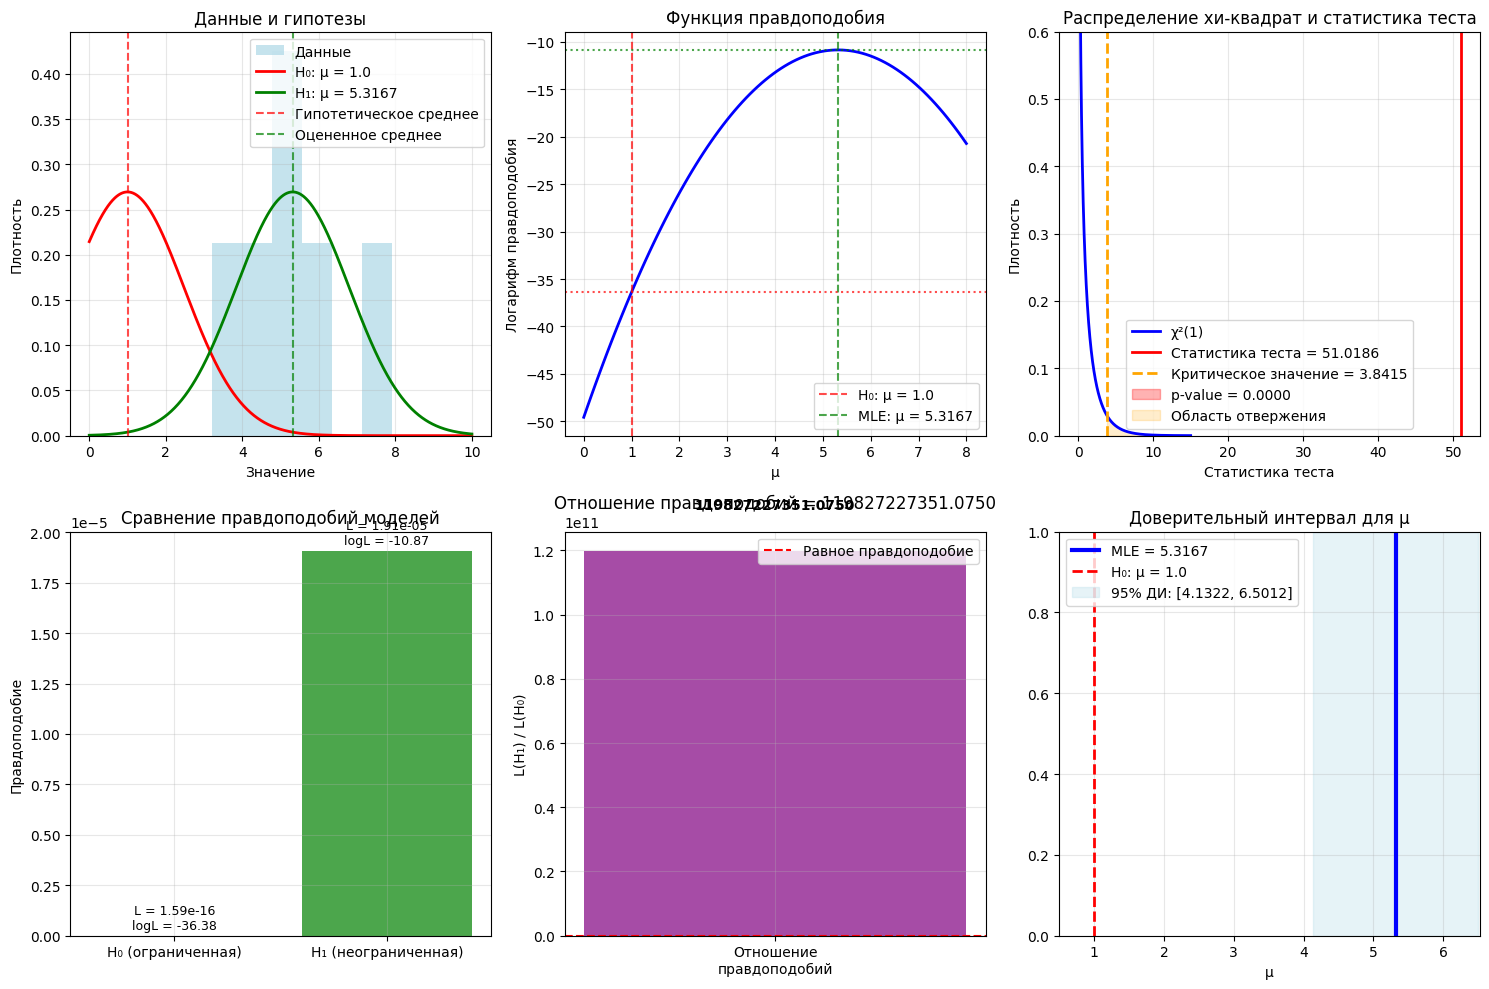


Заключение:
✅ ОТВЕРГАЕМ H₀: p-value = 0.0000 < α = 0.05
   Данные статистически значимо противоречат гипотезе μ = 1.0
   Оцененное значение μ = 5.3167 значимо отличается от 1.0

Дополнительная информация:
95% доверительный интервал для μ: [4.1322, 6.5012]
Гипотетическое значение μ = 1.0 НЕ попадает в доверительный интервал
Отношение правдоподобий L(H₁)/L(H₀) = 119827227351.0750


In [18]:
# 5. Тест отношения правдоподобий с гипотезой о том, что среднее равняется единице
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Наши данные
x = [3.2, 7.9, 5.4, 4.9, 6.2, 4.3]
x = np.array(x)
n = len(x)

# Параметры оценки
mu_hat = np.mean(x)  # MLE оценка
s2_hat = np.var(x, ddof=0)  # MLE оценка дисперсии

print(f"Данные: {x}")
print(f"Оценка MLE для μ: {mu_hat:.4f}")
print(f"Оценка MLE для σ²: {s2_hat:.4f}")

# Шаг 1: Визуализация данных и гипотез
plt.figure(figsize=(15, 10))

# Подграфик 1: Гистограмма данных с наложенными распределениями
plt.subplot(2, 3, 1)
x_range = np.linspace(0, 10, 1000)
hypo_mu = 1.0

# Распределение при H0 (μ = 1)
pdf_h0 = stats.norm.pdf(x_range, loc=hypo_mu, scale=np.sqrt(s2_hat))
# Распределение при H1 (μ = mu_hat)
pdf_h1 = stats.norm.pdf(x_range, loc=mu_hat, scale=np.sqrt(s2_hat))

plt.hist(x, bins=6, density=True, alpha=0.7, color='lightblue', label='Данные')
plt.plot(x_range, pdf_h0, 'r-', linewidth=2, label=f'H₀: μ = {hypo_mu}')
plt.plot(x_range, pdf_h1, 'g-', linewidth=2, label=f'H₁: μ = {mu_hat:.4f}')
plt.axvline(hypo_mu, color='red', linestyle='--', alpha=0.7, label='Гипотетическое среднее')
plt.axvline(mu_hat, color='green', linestyle='--', alpha=0.7, label='Оцененное среднее')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Данные и гипотезы')
plt.legend()
plt.grid(True, alpha=0.3)

# Шаг 2: Функция правдоподобия
plt.subplot(2, 3, 2)
mu_range = np.linspace(0, 8, 100)
log_likelihoods = []

for mu in mu_range:
    logL = np.sum(stats.norm.logpdf(x, loc=mu, scale=np.sqrt(s2_hat)))
    log_likelihoods.append(logL)

plt.plot(mu_range, log_likelihoods, 'b-', linewidth=2)
plt.axvline(hypo_mu, color='red', linestyle='--', alpha=0.7, label=f'H₀: μ = {hypo_mu}')
plt.axvline(mu_hat, color='green', linestyle='--', alpha=0.7, label=f'MLE: μ = {mu_hat:.4f}')
plt.axhline(np.sum(stats.norm.logpdf(x, loc=hypo_mu, scale=np.sqrt(s2_hat))), 
           color='red', linestyle=':', alpha=0.7)
plt.axhline(np.sum(stats.norm.logpdf(x, loc=mu_hat, scale=np.sqrt(s2_hat))), 
           color='green', linestyle=':', alpha=0.7)
plt.xlabel('μ')
plt.ylabel('Логарифм правдоподобия')
plt.title('Функция правдоподобия')
plt.legend()
plt.grid(True, alpha=0.3)

# Вычисление статистики теста
logL_R = np.sum(stats.norm.logpdf(x, loc=hypo_mu, scale=np.sqrt(s2_hat)))     # при H0
logL_UR = np.sum(stats.norm.logpdf(x, loc=mu_hat, scale=np.sqrt(s2_hat)))     # при H1

test_statistic = -2 * (logL_R - logL_UR)
alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, df=1)
p_value = 1 - stats.chi2.cdf(test_statistic, df=1)

print(f"\nРезультаты теста:")
print(f"logL(H₀): {logL_R:.4f}")
print(f"logL(H₁): {logL_UR:.4f}")
print(f"Статистика теста: -2*(logL_R - logL_UR) = {test_statistic:.4f}")
print(f"Критическое значение (α=0.05): {critical_value:.4f}")
print(f"p-value: {p_value:.4f}")

# Шаг 3: Распределение статистики теста
plt.subplot(2, 3, 3)
chi2_range = np.linspace(0, 15, 1000)
chi2_pdf = stats.chi2.pdf(chi2_range, df=1)

plt.plot(chi2_range, chi2_pdf, 'b-', linewidth=2, label='χ²(1)')
plt.axvline(test_statistic, color='red', linestyle='-', linewidth=2, 
           label=f'Статистика теста = {test_statistic:.4f}')
plt.axvline(critical_value, color='orange', linestyle='--', linewidth=2, 
           label=f'Критическое значение = {critical_value:.4f}')

# Закрашиваем область p-value
p_value_region = chi2_range[chi2_range >= test_statistic]
plt.fill_between(p_value_region, 0, stats.chi2.pdf(p_value_region, df=1), 
                alpha=0.3, color='red', label=f'p-value = {p_value:.4f}')

# Закрашиваем область отвержения
rejection_region = chi2_range[chi2_range >= critical_value]
plt.fill_between(rejection_region, 0, stats.chi2.pdf(rejection_region, df=1), 
                alpha=0.2, color='orange', label='Область отвержения')

plt.xlabel('Статистика теста')
plt.ylabel('Плотность')
plt.title('Распределение хи-квадрат и статистика теста')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.6)

# Шаг 4: Сравнение правдоподобий
plt.subplot(2, 3, 4)
models = ['H₀ (ограниченная)', 'H₁ (неограниченная)']
log_likelihoods = [logL_R, logL_UR]
likelihoods = [np.exp(logL_R), np.exp(logL_UR)]

bars = plt.bar(models, likelihoods, color=['red', 'green'], alpha=0.7)
plt.ylabel('Правдоподобие')
plt.title('Сравнение правдоподобий моделей')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, likelihood, logL in zip(bars, likelihoods, log_likelihoods):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(likelihoods),
             f'L = {likelihood:.2e}\nlogL = {logL:.2f}',
             ha='center', va='bottom', fontsize=9)

# Шаг 5: Отношение правдоподобий
plt.subplot(2, 3, 5)
LR = np.exp(logL_UR - logL_R)  # Отношение правдоподобий
plt.bar(['Отношение\nправдоподобий'], [LR], color='purple', alpha=0.7)
plt.axhline(1, color='red', linestyle='--', label='Равное правдоподобие')
plt.ylabel('L(H₁) / L(H₀)')
plt.title(f'Отношение правдоподобий = {LR:.4f}')
plt.grid(True, alpha=0.3)
plt.legend()

# Добавляем значение на столбец
plt.text(0, LR + 0.1 * LR, f'{LR:.4f}', ha='center', va='bottom', fontweight='bold')

# Шаг 6: Доверительные интервалы
plt.subplot(2, 3, 6)
# Асимптотический доверительный интервал для μ
z_alpha = stats.norm.ppf(1 - alpha/2)
se_mu = np.sqrt(s2_hat / n)  # стандартная ошибка
ci_lower = mu_hat - z_alpha * se_mu
ci_upper = mu_hat + z_alpha * se_mu

plt.axvline(mu_hat, color='blue', linewidth=3, label=f'MLE = {mu_hat:.4f}')
plt.axvline(hypo_mu, color='red', linewidth=2, linestyle='--', label=f'H₀: μ = {hypo_mu}')
plt.axvspan(ci_lower, ci_upper, alpha=0.3, color='lightblue', 
           label=f'95% ДИ: [{ci_lower:.4f}, {ci_upper:.4f}]')

plt.xlabel('μ')
plt.title('Доверительный интервал для μ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min(mu_hat - 2*se_mu, hypo_mu - 0.5), max(mu_hat + 2*se_mu, hypo_mu + 0.5))

plt.tight_layout()
plt.show()

# Заключение
print(f"\nЗаключение:")
if p_value < alpha:
    print(f"✅ ОТВЕРГАЕМ H₀: p-value = {p_value:.4f} < α = {alpha}")
    print(f"   Данные статистически значимо противоречат гипотезе μ = {hypo_mu}")
    print(f"   Оцененное значение μ = {mu_hat:.4f} значимо отличается от {hypo_mu}")
else:
    print(f"✅ НЕТ ОСНОВАНИЙ ОТВЕРГАТЬ H₀: p-value = {p_value:.4f} ≥ α = {alpha}")
    print(f"   Данные согласуются с гипотезой μ = {hypo_mu}")

print(f"\nДополнительная информация:")
print(f"95% доверительный интервал для μ: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Гипотетическое значение μ = {hypo_mu} {'НЕ ' if hypo_mu < ci_lower or hypo_mu > ci_upper else ''}попадает в доверительный интервал")
print(f"Отношение правдоподобий L(H₁)/L(H₀) = {LR:.4f}")

6. А теперь тест отношения правдоподобий с гипотезой о том, что среднее равно единице, а дисперсия двойке

In [ ]:
### YOUR CODE HERE

## Практика

* На практике для давно известных распределений никто не оценивает параметры ММП в каждой задаче, а просто используют уже известные оценки, выведенные в общем виде.

* Например, для аналитики спорта очень часто используют Пуассоновское распределение.

* Им моделируют, например, общее кол-во голов в матче, голы домашней команды, команды соперника, кол-во успешных действий конкретного игрока, кол-во красных и желтых карточек... В общем любой "подсчет" в единицу времени

* В этой практике попробуем немного погрузиться в экономику спорта

В данной задачи будем использовать данные с <https://footystats.org/> о матчах в самых известных футбольных премьер лигах за 5 последних сезонов.

Данные можно загрузить по ссылке: https://drive.google.com/drive/folders/16WZMzHd74W-O_NdUgsEPjJ9rTXywsN1t?usp=drive_link

Описание данных можно найти здесь: https://footystats.org/api/documentations/match-schedule-and-stats

### TASK 1 (OPTIONAL) 

Если есть желание попрактиковаться, попробуйте вывести оценки ММП для распределение Пуассона в общем виде

In [ ]:
### YOUR CODE OR LATEX HERE

### TASK 2: Спорт как Пуассоновская модель

* Объедините все голы, забитые во всех матчах: и домашние, и гостевые, либо возьмите готовый столбец из данных. 

* Предположив, что общее количество голов в лиге подчиняется распределению Пуассона, найдите оценку максимального правдоподобия для параметра λ (среднее количество голов за матч в лиге)

* Насколько она устойчива к изменению выборки (например, если взять только матчи одной команды или одного сезона)?

* Графические иллюстрации приветствуются, но не обязательны :)

In [ ]:
### YOUR CODE HERE

### TASK 3: Стиль игры

1. Выберите одну конкретную команду. Оцените два параметра:

* λ_attack – среднее количество голов, забиваемое этой командой за матч (используйте данные по всем матчам, где она играла).

* λ_defence – среднее количество голов, пропускаемых этой командой за матч.

2. Сравните λ_attack и λ_defence для этой команды. Что это говорит о ее стиле игры? Является ли она атакующей, оборонительной или сбалансированной?

In [ ]:
### YOUR CODE HERE

### TASK 4: Существует ли эффект домашнего поля?

* Формулировка гипотезы: Команды в среднем забивают больше голов, играя дома, чем в гостях.


1. Для выбранной команды (или для всех команд в совокупности) оцените λ_home (средние голы дома) и λ_away (средние голы в гостях).

2. Постройте 95% доверительные интервалы для λ_home и λ_away (можно использовать свойство асимптотической нормальности оценки ММП). Перекрываются ли они?

3. Проверьте гипотезу H₀: λ_home = λ_away против H₁: λ_home > λ_away (Hint: можно использовать тест отношения правдоподобия).

In [17]:
### YOUR CODE HERE